In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm
import sympy as sy
import seaborn as sb
from scipy.stats import vonmises
from astropy.stats import circmean
import filterpy
from filterpy import monte_carlo
from filterpy.monte_carlo import stratified_resample


# import particles  # core module
# from particles import distributions as dists  # where probability distributions are defined
# from particles import state_space_models as ssm  # where state-space models are defined
# from particles.collectors import Moments


In [47]:
#testing random stuff
test_w = np.ones(100)
# test_w = (1/100)*test_w
print(stratified_resample(test_w))

test_angles = np.random.uniform(0,2*np.pi,100)
print(circmean(test_angles,weights=test_w))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1.7338703688240298


In [20]:
"""
A copy of our Kalman Filter Class, for comparison and to generate data
"""

class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        # inialize everything
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u

    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        
        # set n and m to be useful
        n = len(x0)
        m = len(self.H)

        # initialize and empty state and obs matrices
        states = np.zeros((n, N))
        obs = np.zeros((m,N))

        # do the first pass
        states[:,0] = x0
        obs[:,0] = (self.H @ x0 + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        for i in range(N-1):
            # iterate 
            states[:,i+1] = (self.F @ states[:,i] + self.u + np.random.multivariate_normal(mean=np.zeros(n), cov=self.Q)) % (2*np.pi)
            obs[:,i] = (self.H @ states[:,i] + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        # do the last one
        obs[:,-1] = (self.H @ states[:,-1] + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        # return the states and obs
        return states, obs
    

    def estimate(self,x0,P0,z, return_norms = False, circular=True):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        # get the N, n and initalize an out
        n = len(x0)
        N = z.shape[1]
        out = np.zeros((n, N))

        # set the first value
        out[:,0] = x0

        # iterate 
        for i in range(1,N):
            # we get the temp  by subtracting the observation from the predicted obs
            temp = (z[:,i] - (self.H @ out[:,i-1])) 
            
            # update
            # now yk is either what it is or we shift on the circle no we multiply by the sign to get negatives that are needed
            if circular:
                y = []
                for t in temp: # go through all the angles TODO make this nicer
                    if np.abs(t) > np.pi and t < 0: # first we see if the |angle| is bigger than pi and negative then we shift it back 2pi
                        t += 2*np.pi
                    elif np.abs(t) > np.pi and t > 0: # now we see if the angle is positive to shift it forward 2pi
                        t -= 2*np.pi
                    y.append(t)
                # now save it in the array
                yk = np.array(y)
                # yk = np.minimum(np.abs(temp), 2*np.pi - np.abs(temp)) * np.sign(temp)


            else:
                yk = temp
            Sk = self.H @ P0 @ self.H.T + self.R
            Kk = P0 @ self.H.T @ inv(Sk)

            xk = (out[:,i-1] + Kk @ yk) # % (2*np.pi)
            Pk = ((np.eye(n) - Kk @ self.H) @ P0).copy()

            # predict
            out[:,i] = (self.F @ xk + self.u) % (2*np.pi)

            P0 = self.F @ Pk @ self.F.T + self.Q
        
        # return out
        return out
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        # get the n and initialize and out
        n = len(x)
        out =  np.zeros((n,k))

        # set the first value
        out[:,0] = x
        for i in range(1, k):
            # iterate through 
            out[:,i] = self.F @ out[:,i-1] + self.u

        # return out
        return out
    
    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        # get the n and make an empty out
        n = len(x)
        out =  np.zeros((n,k))

        # do the last one
        out[:,-1] = x

        # save F inverse so we don't compute it everytime
        F_inv = inv(self.F)
        for i in range(1, k):
            # iterate backwards
            out[:,-i-1] = F_inv @ (out[:,-i] - self.u)

        # return out
        return out
         

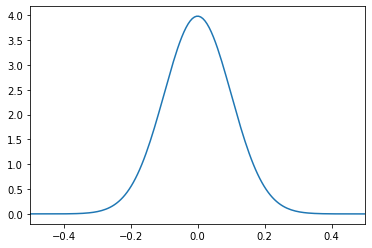

11.459155902616466



In [17]:
angles = np.linspace(-np.pi,np.pi,1000)
loc = 0
kappa = 100
von_m = vonmises.pdf(loc,kappa,angles)
plt.plot(angles,von_m)
plt.xlim([-.5,.5])
plt.show()
print(np.rad2deg(.2))

#test weighted circular mean
angles = vonmises(loc=np.pi, kappa=1).rvs(1000)
test_weights = np.random.random(size=1000)
test_weights = test_weights/np.sum(test_weights)
print()

In [70]:
class ParticleFilter(object):    
    def __init__(self,F,H,K1,K2,N_particles):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        K1 : float
            the "circular variance" of the system's noise. Kappa 1.
        H : ndarray of shape (m,n)
            The observation matrix.
        K2 : ndarray of shape (m,m)
            The "circular variance" for observation noise. Kappa 2.
        """
        #Our state vector is:
        #x0=currenet angle, x1 = previous angle, x2 = angular velocity
        
        # inialize everything
        self.K1 = K1
        self.K2 = K2
        self.H = H
        self.F=F
        #We initialize our particles as 0 angular velocity, uniformly distributed angles on [0,2π]
        self.N_particles = N_particles
        self.particles = np.zeros((N_particles,F.shape[0]))
        self.particles[:,0] = np.random.uniform(0,2*np.pi,N_particles)
        self.particles[:,1] = self.particles[:,0]
        #We initialize the particles weights to all be equal:
        self.weights = 1/N_particles*np.ones(N_particles)
    def creat_uniform_particles(N):
        """
        returns uniformly distributed particles and their weights
        """
        return np.random.uniform(0,2*np.pi,N),1/N * np.ones(N)
    def create_von_mises_particles(self,loc,kappa,N):
        """
        returns von mises distributed particles and their weights
        """
        particles = vonmises(loc=loc, kappa=kappa).rvs(N)
        weights = vonmises(loc=loc, kappa=kappa).pdf(particles)
        return particles,weights
    def predict_particles(self,particles):
        #predicts the next state of the particles, adding noise into the prediction as well
        #I'm really not sure what kappa variable to use for our noise on both ends
        noise = np.zeros_like(particles)
        noise_new_state = self.create_von_mises_particles(loc=0,kappa=25,N=self.N_particles)[0]
        noise[:,0] = noise_new_state
        #I feel like we don't want noise in our angular velocity estimate or our previous state that we just want to keep track of

        new_particles= particles@(self.F.T) + noise #want to do (F@particles.T).T including noise
        new_particles = new_particles# %(2*np.pi)#Make sure it's in the range of 0,2pi
        return new_particles
    def update_particles(self,particles,weights,obs):
        """
        obs: (n_obs,) ndarray of observations


        Updates the particle weights using Bayesian Posterior probability.
        P(particle|data) = P(particle)*P(data|particle)
        => new_weight = old_weight * von_mises(data|mean=particle,kappa=K2)
        The "Prior" is just the weight from the previous step.
        The "Likelihood" is just the probability of the data from von mises with mean centered at the particle

        We only calculate the weights based on the current angle estimate, ignoring states 2 and 3

        Returns:
            new_weights: array like weights
        """
        predicted_angles = particles[:,0]
        new_weights = np.copy(weights)

        #Calculate the average likelihood?
        tot_likelihood = np.zeros_like(new_weights)
        for ang in obs:
            likelihood = vonmises(loc=ang, kappa=self.K2).pdf(predicted_angles)
            tot_likelihood += likelihood
        tot_likelihood = tot_likelihood/ len(obs)

        #Get the posterior weights
        new_weights = new_weights*tot_likelihood
        #rescale to make them sum to 1 so they're a probability distribution
        new_weights = new_weights/np.sum(new_weights)
        return new_weights

    def state_estimate_from_particles(self,particles,weights):
        #Computes the WEIGHTED circular mean of the particles (just the current angle)
        return circmean(particles[:,0],weights=weights)%(2*np.pi)

    def resample(self,particles,weights):
        """
        Re-sample from our current particles, using filterpy to do so
        
        Returns:
            particles_chosen
            updated_weights
        """
        particles_chosen = stratified_resample(weights)
        updated_weights = weights[particles_chosen]

        return particles[particles_chosen,:],updated_weights
    def neff(weights):
        #This is the "effective" number of particles. If this falls below a threshold, we need to resample
        return 1. / np.sum(np.square(weights))

    def filter_particle(self,obs):
        """
        Performs the particle filter routine for the entire dataset
        Returns a sequence of state estimates for each time step.
        """
        tot_particles = []
        state_estimates = np.zeros(obs.shape[1])
        for i in range(obs.shape[1]):
            tot_particles.append(self.particles)
            #start by updating the weights of the particles
            current_obs = obs[:,i]
            self.weights = self.update_particles(self.particles,self.weights,current_obs)
            
            #Every so often, we want to resample:
            # if i%5 ==0:
            self.particles,self.weights = self.resample(self.particles,self.weights)
            
            #Compute our state estimate
            state_estimates[i] = self.state_estimate_from_particles(self.particles,self.weights)

            #Predict the next state of the particles
            self.particles = self.predict_particles(self.particles)
        return state_estimates,tot_particles      

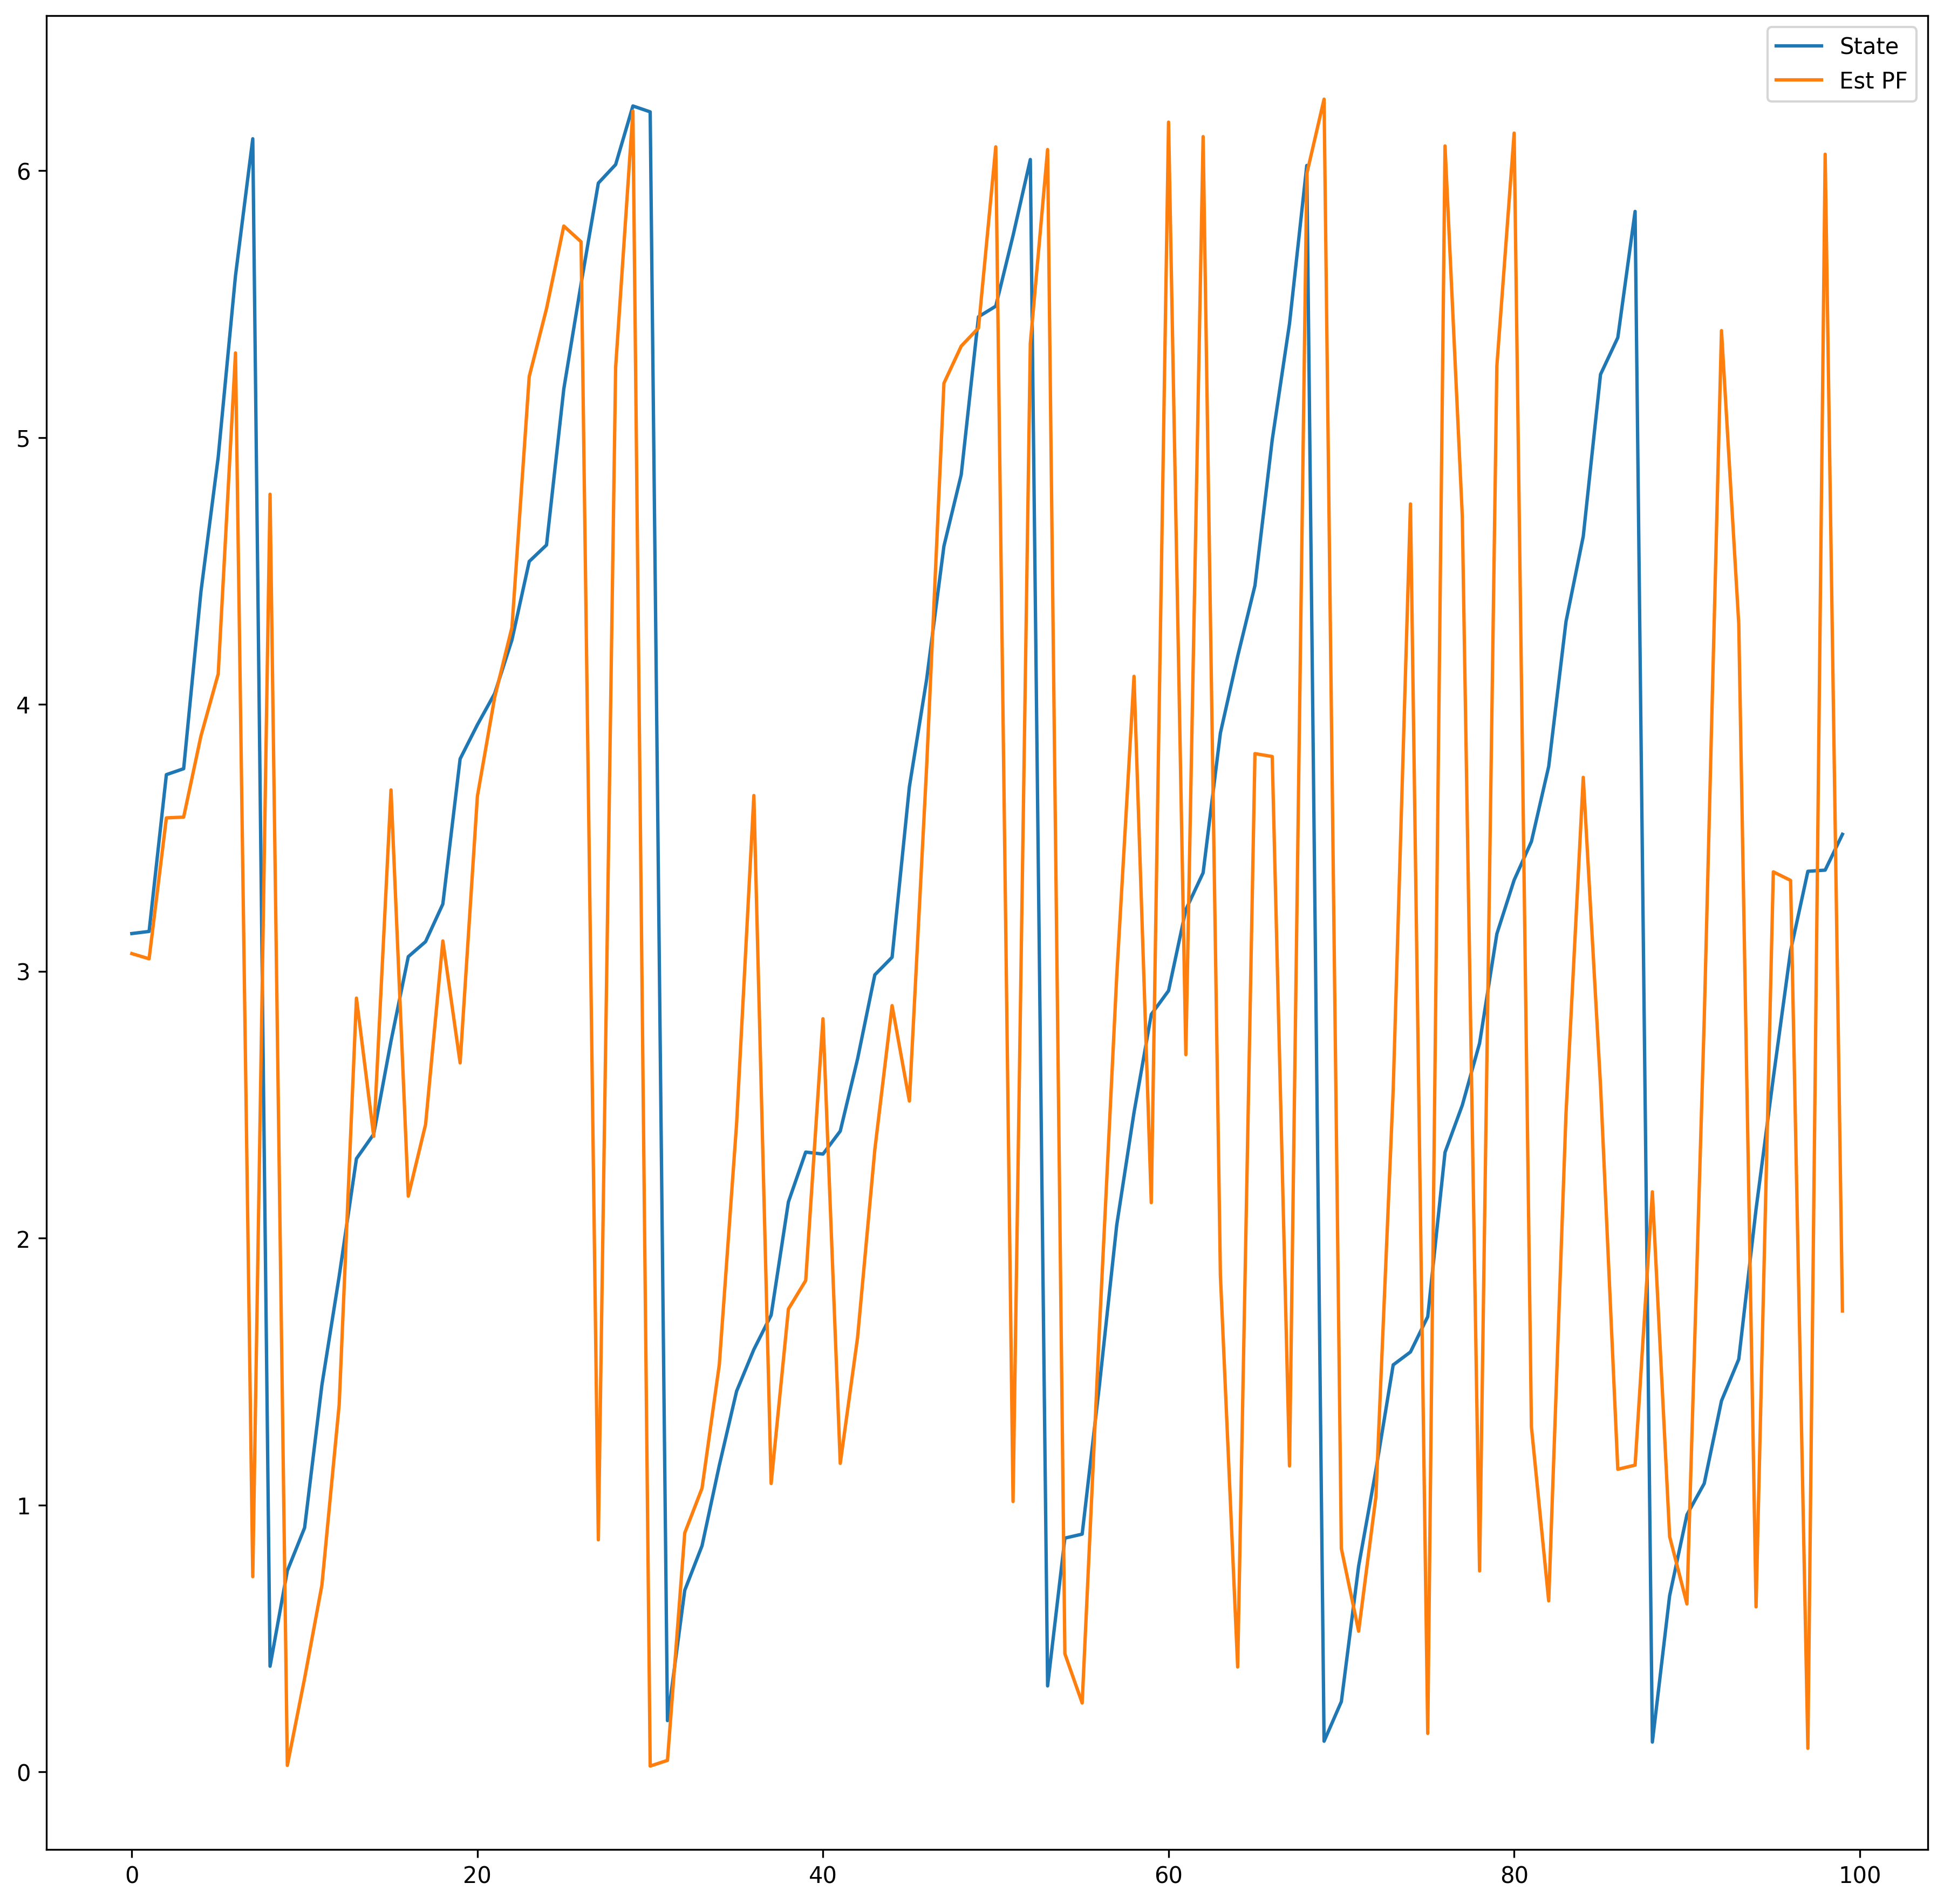

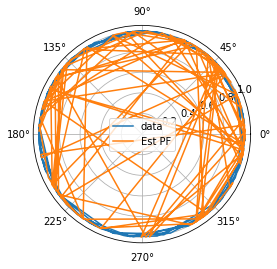

[3.06647539 3.04701613 3.57497676 3.57790532 3.88184337 4.11443321
 5.31716538 0.73171945 4.78774497 0.02467334 0.35107345 0.69971282
 1.37572017 2.89962437 2.38172636 3.67973221 2.15772558 2.42608747
 3.11385065 2.65685482 3.65618315 4.02669081 4.28896719 5.22907697
 5.48313749 5.7926501  5.73368014 0.86995896 5.26336807 6.22349676
 0.02219364 0.04341636 0.89550487 1.06324208 1.52628976 2.42842708
 3.65876586 1.08089916 1.73473586 1.84153845 2.82241529 1.15638546
 1.62687512 2.33172198 2.87150806 2.51413483 3.76824781 5.20369529
 5.34264564 5.41073034 6.0893433  1.01365869 5.35280256 6.07922547
 0.44284891 0.25837482 1.66052747 2.98181686 4.10540999 2.13328421
 6.18196357 2.6878572  6.12754942 1.86119299 0.3934143  3.81578609
 3.80491093 1.14685255 5.98880504 6.2679808  0.83726778 0.52768301
 1.03133614 2.555492   4.75133144 0.14451343 6.0926788  4.70533836
 0.7534061  5.26823795 6.14090319 1.29328272 0.64129229 2.46594496
 3.72686791 2.57187602 1.13419948 1.14975811 2.17392701 0.8820

In [71]:
#TESTS THE PARTICLE FILTER

#Initialize Kalman Filter Params, generate data
Q = np.eye(3) * 0.001
R = np.eye(18) * 0.5 
u = np.zeros(3)


#Initialize state transition matrix and other params
deltat = 0.1
F = np.array([[1,0,deltat],
              [1,0,0],
              [deltat**-1, deltat**-1, 0]])

H = np.zeros((18,3))
H[:,0] = np.ones(18)
kf = KalmanFilter(F, Q, H, R, u)

#Initialize Particle Filter
K1 = 5
K2 = 5
N_particles = 100
#Initialize the filter
p_filter = ParticleFilter(F,H,K1,K2,N_particles)

n_steps = 100
x0 = np.array([np.pi, np.pi, 0])
states, obs = kf.evolve(x0, n_steps)

state_estimates,particles = p_filter.filter_particle(obs)
# print(state_estimates)

#estimate the states with both the good and the bad Kalman Filters
est_b = kf.estimate(np.array([np.pi, np.pi, 0]), np.eye(3)*0.001, obs[:,:], circular=False)
est_g = kf.estimate(np.array([np.pi, np.pi, 0]), np.eye(3)*0.001, obs[:,:], circular=True)

t = np.arange(n_steps)
plt.figure(dpi=300,figsize=(15,15))
plt.plot(states[0], label='State')
# plt.plot(obs[0], 'o',label = 'Observation')
# plt.plot(est_b[0], label='Est Plain old')
# plt.plot(est_g[0], label='Est Circular')

#Now plot the PF estimate
plt.plot(state_estimates, label='Est PF')

plt.legend()
plt.show()

plt.polar(states[0], np.ones_like(states[0]),label ='data')
# plt.polar(obs[0], np.ones_like(obs[0]), 'o',label = 'Observation')
# plt.polar(est_g[0], np.ones_like(est_g[0]))
# plt.polar(est_b[0], np.ones_like(est_b[0]))

#Now plot the PF estimate
plt.polar(state_estimates,np.ones_like(state_estimates), label='Est PF')
plt.legend()
plt.show()

print(state_estimates)

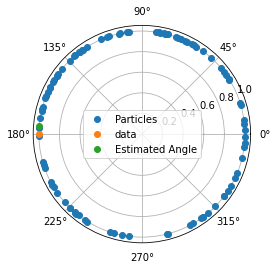

In [72]:
#Animate the particle plot:
from matplotlib.animation import FuncAnimation

# Function to update the plot for each frame
def update(frame):
    part = particles[frame]
    part = part[:,0]
    ax.clear()
    #Plot all the particles at the current time step
    ax.plot(part,np.ones_like(part),'o',label = 'Particles')
    ax.plot(states[0,frame], 1,'o',label ='data')  # Plot current angle
    ax.plot(state_estimates[frame],1,'o', label='Estimated Angle')
    ax.legend()
    # ax.set_title('Frame {}'.format(frame))

# Create a figure and axis
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Create the animation
ani = FuncAnimation(fig, update, frames=15, interval=1000)  # 50 frames, 1 second per frame

ani.save('Particles.mp4', writer='ffmpeg')